#**02_TERM FREQUENCY AND TFIDF**

Summary:


1.   Load Back Data and Merging
2.   Split *narco_data* into Schedules ([DEA](https://www.dea.gov/drug-information/drug-scheduling))
3.   Term Frequency
4.   TfIdf on Schedule 1 and Schedule 2
5.   TfIdf with respect to Time Periods

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import sys
sys.path.append('/content/drive/My Drive/Università/inforet_prj/')

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import pickle
import spacy
import string
from scipy.stats import norm
import matplotlib.pyplot as plt
import math

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

In [5]:
nlp = spacy.load("en_core_web_sm")

In [24]:
def sort_matrr(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def top_words_tfidfnames, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

## **1. Load Back Data and Merging**

In [ ]:
narco_nlp = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_nlp_21set_nostop.csv", sep="|", names = ['spacy_nlp'], header=None)
narco_nlp

In [ ]:
narco_df = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_df.csv", sep="|")
narco_df

In [ ]:
narco_data.text[538]

In [ ]:
narco_data = pd.concat([narco_df, narco_nlp], axis=1)

In [ ]:
def typo(text):
    cleaned_text = (
        text.replace('cannabi ','cannabis ')
        .replace('lysergic acid diethylamide', 'lsd')
        .replace('methylenedioxymethamphetamine', 'mdma')
        .replace('methylenedioxyamphetamine', 'mda')
        .replace(' meth ', ' methamphetamine ')
        .replace('meth[amphetamine]', 'methamphetamine')
        .replace('pseudo-ephedrine', 'pseudoephedrine')
        .replace(' homogenous ', ' 	homogeneous ')
        .replace('methamphetaminemanufacturing', 'methamphetamine manufacturing')
        .replace('controued', 'controlled')
        .replace('ciacetyl','diacetyl')
        .replace(' nar cotic', ' narcotic')
        .replace(' kilo ', ' kilogram ')
        .replace(' crosses ', ' cross ')
        .replace(' vick ', '')
        .replace(' fi ','')
        )
    return cleaned_text

In [ ]:
narco_data = narco_data.rename(columns= {'spacy_nlp':'lemmatized'})
narco_data.lemmatized

In [ ]:
narco_data['lemmatized'] = narco_data.lemmatized.progress_apply(lambda txt: typo(txt))

In [ ]:
del narco_df
del narco_nlp

In [ ]:
import gc
gc.collect()

153

### *1.1 Serialize narco_data*

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "wb") as f:
    pickle.dump(narco_data, f)

---

## **2. Split *narco_data* into Schedules**

In [6]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "rb") as f:
    narco_data = pickle.load(f)

In [7]:
schedule_1 = ["cannabis",  "marijuana",  "lsd", "heroin", 'methaqualone', "ecstasy", "peyote", "mescaline", "mda", "mdma"] #https://www.dea.gov/drug-information/drug-scheduling
schedule_2 = ["cocaine", "methamphetamine", "hydromorphone", "dilaudid", "meperidine", "demerol", "oxycodone", "dexedrine", "fentanyl", "ritalin", "methadone", "amphetamine", "phencyclidine", "pseudoephedrine", "ephedrine", "opium", "dilaudid", "preludin"]
schedule_3 = ["ketamine", "anabolic" , "steroids",  "testosterone", "ketamine"]
schedule_4 = ["modafinil", "provigil", "adderall", "methylphenidate", "memantine", "axura", "soma", "xanax", "darvon", "darvocet", "valium", "ativan", "talwin", "ambien", "tramadol",  "ethclorvynol"]
schedule_5 = ["phenylpropanolamine", "lomotil", "motofen", "lyrica", "parepectolin", "tetracaine"]

In [ ]:
conditions = [
    (narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5)))
    ]

# create a list of the values we want to assign for each condition
values = ['narco_1', 'narco_2', 'narco_3', 'narco_4']

# create a new column and use np.select to assign values to it using our lists as arguments
narco_data['schedule'] = np.select(conditions, values)

# display updated DataFrame
narco_data.head()

In [9]:
narco_sch = narco_data.loc[:, ["schedule", "lemmatized", "year"]]

In [10]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_sch.pkl", "wb") as f:
    pickle.dump(narco_sch, f)

In [ ]:
# NARCO SCHEDULE MERGE
# Merge in one row all the opinions in the same schedule.
# We obtain narco_schedule with shape 5,2:
#   _0 (miscellaneous), narco_1, narco_2, narco_3, narco_4;
#   _schedule label and lemmatized corpora.

narco_schedule = narco_sch.groupby('schedule', as_index=False).agg({'lemmatized' : ' '.join}) 

In [ ]:
narco_sch.loc[narco_sch.schedule == '0']

In [ ]:
narco_schedule.lemmatized.str.split(" ").map(len)

0    2893975
1    1542179
2    2752970
3       2002
4      17815
Name: lemmatized, dtype: int64

### *2.1 Serialize narco_schedule*

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_schedule.pkl", "wb") as f:
    pickle.dump(narco_schedule, f)

---

## **3. Term Frequency**

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_schedule.pkl", "rb") as f:
  narco_schedule = pickle.load(f)

In [ ]:
# Divide into schedules
narco_schedule_1 = narco_schedule.loc[narco_schedule['schedule']=="narco_1"] # 1421     
narco_schedule_2 = narco_schedule.loc[narco_schedule['schedule']=="narco_2"] # 2287   
#narco_schedule_3 # 1
#narco_schedule_4 # 6

In [ ]:
nar = narco_schedule[(narco_schedule.schedule == 'narco_1') | (narco_schedule.schedule =='narco_2')]

In [ ]:
vectorizer = CountVectorizer()
vector_narco = vectorizer.fit_transform(nar['lemmatized'])

words_list = vectorizer.get_feature_names()
count_list = vector_narco.toarray().sum(axis=0)

w = dict(zip(words_list, count_list))
w = {k: v for k, v in sorted(w.items(), key=lambda item: item[1], reverse=True)}

mcw = pd.DataFrame.from_dict(w, orient='index').reset_index()
mcw.columns = ["words_tot", "abs_freq"]

mcw["rel_freq"] = mcw.progress_apply(lambda x: np.round(x.abs_freq / mcw.abs_freq.sum(), 3), axis=1)

mcw[:50]

100%|██████████| 22663/22663 [00:03<00:00, 7287.93it/s]


,words_tot,abs_freq,rel_freq
0,defendant,184390,0.043
1,trial,70525,0.016
2,evidence,47484,0.011
3,testify,32590,0.008
4,find,30813,0.007
5,officer,28370,0.007
6,police,26679,0.006
7,testimony,23345,0.005
8,state,22919,0.005
9,jury,22180,0.005


In [ ]:
vectorizer = CountVectorizer()
#words_list = vectorizer.get_feature_names()
#
X = vectorizer.fit_transform(narco_schedule_1['lemmatized'])
words_list_1 = vectorizer.get_feature_names()
count_list_1 = X.toarray().sum(axis=0)
w_1 = dict(zip(words_list_1, count_list_1))
w_1 = {k: v for k, v in sorted(w_1.items(), key=lambda item: item[1], reverse=True)}
mcw_1 = pd.DataFrame.from_dict(w_1, orient='index').reset_index()
mcw_1.columns = ["words_1", "abs_freq"]
mcw_1["rel_freq"] = mcw_1.progress_apply(lambda x: np.round(x.abs_freq / mcw_1.abs_freq.sum(), 3), axis=1)
mcw_1["log_freq"] = mcw_1.progress_apply(lambda x: np.round(1+(math.log(x.abs_freq,5)), 3), axis=1)
mcw_1["augm_freq"] = mcw_1.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw_1.abs_freq.max()), 3), axis=1)
#
Y = vectorizer.fit_transform(narco_schedule_2['lemmatized'])
words_list_2 = vectorizer.get_feature_names()
count_list_2 = Y.toarray().sum(axis=0)
w_2 = dict(zip(words_list_2, count_list_2))
w_2 = {k: v for k, v in sorted(w_2.items(), key=lambda item: item[1], reverse=True)}
mcw_2 = pd.DataFrame.from_dict(w_2, orient='index').reset_index()
mcw_2.columns = ["words_2", "abs_freq"]
mcw_2["rel_freq"] = mcw_2.progress_apply(lambda x: np.round(x.abs_freq / mcw_2.abs_freq.sum(), 3), axis=1)
mcw_2["log_freq"] = mcw_2.progress_apply(lambda x: np.round(1+(math.log(x.abs_freq,5)), 3), axis=1)
mcw_2["augm_freq"] = mcw_2.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw_2.abs_freq.max()), 3), axis=1)

100%|██████████| 19252/19252 [00:02<00:00, 9393.27it/s]


In [ ]:
mcw_1_2_concat = pd.concat([mcw_1[:20],mcw_2[:20]], axis=1)
mcw_1_2_concat # WORDS = tinfou, mitte, wtappe

,words_1,abs_freq,rel_freq,log_freq,augm_freq,words_2,abs_freq,rel_freq,log_freq,augm_freq
0,defendant,64578,0.042,7.882,1.000,defendant,119812,0.044,8.266,1.000
1,trial,24111,0.016,7.270,0.687,trial,46414,0.017,7.676,0.694
2,evidence,16567,0.011,7.036,0.628,evidence,30917,0.011,7.424,0.629
3,testify,11648,0.008,6.817,0.590,testify,20942,0.008,7.182,0.587
4,officer,11531,0.007,6.811,0.589,find,19669,0.007,7.143,0.582
5,find,11144,0.007,6.790,0.586,police,16901,0.006,7.049,0.571
6,police,9778,0.006,6.709,0.576,officer,16839,0.006,7.046,0.570
7,testimony,8980,0.006,6.656,0.570,jury,15039,0.005,6.976,0.563
8,search,8694,0.006,6.636,0.567,state,15021,0.005,6.976,0.563
9,arrest,7955,0.005,6.581,0.562,testimony,14365,0.005,6.948,0.560


In [ ]:
common_terms = list(set(mcw_1["words_1"][:10].values).intersection(set(mcw_2["words_2"][:200].values)))
common_terms

['testimony',
 'search',
 'trial',
 'officer',
 'police',
 'defendant',
 'find',
 'testify',
 'arrest',
 'evidence']

In [ ]:
# COMMON
a = mcw.words_tot[:50]
b = mcw_1.words_1[:50]
c = mcw_2.words_2[:50]
ab = pd.DataFrame([ element for element in a if element in b], columns = ['tot_narco1'])
ac = pd.DataFrame([ element for element in a if element in c], columns = ['tot_narco2'])
bc = pd.DataFrame([ element for element in b if element in c], columns = ['narco1_narco2'])
#x = pd.concat([ab, ac,bc],axis=1 ) 
bc

,narco1_narco2


In [ ]:
df_top50 = pd.concat([a, b, c],axis=1) ## MOLTO STRANO!!
df_top50[:10]

,words_tot,words_1,words_2
0,defendant,defendant,defendant
1,trial,trial,trial
2,evidence,evidence,evidence
3,testify,testify,testify
4,find,officer,find
5,officer,find,police
6,police,police,officer
7,testimony,testimony,jury
8,state,search,state
9,jury,arrest,testimony


In [ ]:
# NOT COMMON ## NON FUNZIONA?!
a = mcw.words_tot[:30]
b = mcw_1.words_1[:30]
c = mcw_2.words_2[:30]
ab = pd.DataFrame([ element for element in a if element not in b], columns = ['tot_narco1'])
ac = pd.DataFrame([ element for element in a if element not in c], columns = ['tot_narco2'])
bc = pd.DataFrame([ element for element in b if element not in c], columns = ['narco1_narco2'])
x = pd.concat([ab, ac,bc], axis=1 ) 
x

,tot_narco1,tot_narco2,narco1_narco2
0,defendant,defendant,defendant
1,trial,trial,trial
2,evidence,evidence,evidence
3,testify,testify,testify
4,find,find,officer
5,officer,officer,find
6,police,police,police
7,testimony,testimony,testimony
8,state,state,search
9,jury,jury,arrest


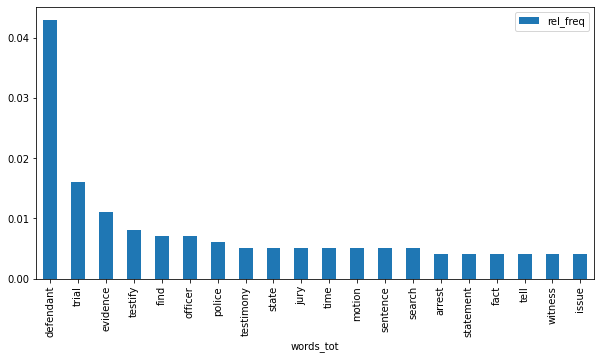

In [ ]:
mcw[:20].plot(x="words_tot", y="rel_freq", kind="bar", figsize=(10,5)) 
plt.show()

In [ ]:
mcw["augm_freq"] = mcw.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw.abs_freq.max()), 3), axis=1)

100%|██████████| 22663/22663 [00:02<00:00, 8870.69it/s]


Text(0, 0.5, 'Augemnted Frequency')

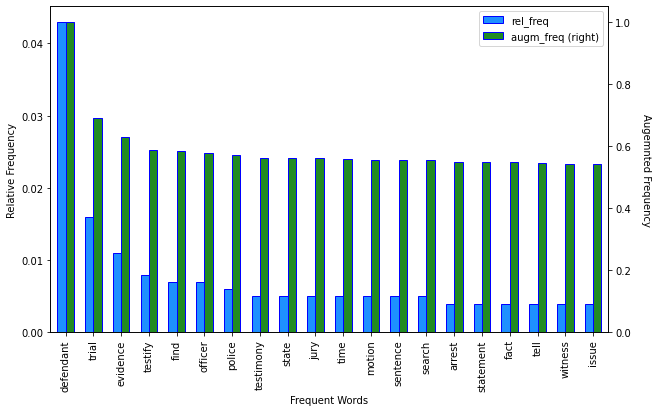

In [ ]:
mcw_freqs = mcw[['words_tot','rel_freq','augm_freq']]
ax = mcw_freqs[:20].plot(kind='bar', x = 'words_tot', secondary_y = 'augm_freq', color={"rel_freq": "dodgerblue", "augm_freq": "forestgreen"}, edgecolor='blue', figsize=(10,6), width= 0.6)

ax.set_xlabel("Frequent Words")
ax.set_ylabel("Relative Frequency")
plt.ylabel('Augemnted Frequency', rotation=-90, labelpad=20)

---

## **4. TfIdf on Schedule 1 and Schedule 2**

In [ ]:
nar = narco_schedule[(narco_schedule.schedule == 'narco_1') | (narco_schedule.schedule =='narco_2')]

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(nar['lemmatized'])
tfidf_1 = tfidf_vectorizer.transform(narco_schedule_1['lemmatized'])
tfidf_2 = tfidf_vectorizer.transform(narco_schedule_2['lemmatized'])
feature_names=tfidf_vectorizer.get_feature_names()
items_1=sort_matr(tfidf_1.tocoo())
items_2=sort_matr(tfidf_2.tocoo())
keyw_1=top_words_tfidf(feature_names,items_1,30)
keyw_2=top_words_tfidf(feature_names,items_2,30)
keyw_1 = pd.DataFrame(list(keyw_1.items()),columns = ['word_1','tfidf_1'])
keyw_2 = pd.DataFrame(list(keyw_2.items()),columns = ['word_2','tfidf_2']) 
tfidf_schedule_drugs = pd.concat([keyw_1, keyw_2], axis=1)
tfidf_schedule_drugs

,word_1,tfidf_1,word_2,tfidf_2
0,defendant,0.719,defendant,0.724
1,trial,0.261,trial,0.281
2,evidence,0.178,evidence,0.188
3,officer,0.130,testify,0.127
4,testify,0.125,find,0.119
5,find,0.123,police,0.101
6,police,0.109,officer,0.098
7,search,0.099,state,0.093
8,testimony,0.095,jury,0.092
9,arrest,0.090,cocaine,0.091


In [ ]:
pd.DataFrame([ element for element in keyw_1.word_1[:20] if element not in keyw_2.word_2[:20]], columns = ['tot_narco1']) ## NON FUNZIONA!!

,tot_narco1
0,defendant
1,trial
2,evidence
3,officer
4,testify
5,find
6,police
7,search
8,testimony
9,arrest


---

## **5. TfIdf with respect to Time Periods**

In [13]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "rb") as f:
  narco_data = pickle.load(f)

In [14]:
schedule_1 = ["cannabis",  "marijuana",  "lsd", "heroin", 'methaqualone', "ecstasy", "peyote" ] #https://www.dea.gov/drug-information/drug-scheduling
schedule_2 = ["cocaine", "methamphetamine", "hydromorphone", "dilaudid", "meperidine", "demerol", "oxycodone", "dexedrine", "fentanyl", "ritalin", "methadone"]
schedule_3 = ["ketamine", "anabolic" , "steroids",  "testosterone"]
schedule_4 = ["modafinil", "provigil", "adderall", "methylphenidate", "memantine", "axura"] #SMART DRUGS 

#### 5.1 **Schedule 1**: *narco_1_time* building

In [15]:
narco_data_1 = narco_data[(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4)))] # 1741 

In [16]:
narco_1_time = narco_data_1.drop(['type','text','author', 'id'], axis = 1)

In [17]:
narco_1_time.loc[(narco_1_time["year"] >= 1950) & (narco_1_time["year"] <= 1959), 'year'] = 50 # 33
narco_1_time.loc[(narco_1_time["year"] >= 1960) & (narco_1_time["year"] <= 1969), 'year'] = 60 # 222
narco_1_time.loc[(narco_1_time["year"] >= 1970) & (narco_1_time["year"] <= 1979), 'year'] = 70 # 560
narco_1_time.loc[(narco_1_time["year"] >= 1980) & (narco_1_time["year"] <= 1989), 'year'] = 80 # 414
narco_1_time.loc[(narco_1_time["year"] >= 1990) & (narco_1_time["year"] <= 1999), 'year'] = 90 # 251
narco_1_time.loc[(narco_1_time["year"] >= 2000) & (narco_1_time["year"] <= 2009), 'year'] = 10 # 229

In [18]:
narco_1_time.loc[narco_1_time["year"] == 50, 'year'] = '50s' 
narco_1_time.loc[narco_1_time["year"] == 60, 'year'] = '60s' 
narco_1_time.loc[narco_1_time["year"] == 70, 'year'] = '70s' 
narco_1_time.loc[narco_1_time["year"] == 80, 'year'] = '80s' 
narco_1_time.loc[narco_1_time["year"] == 90, 'year'] = '90s'
narco_1_time.loc[narco_1_time["year"] == 10, 'year'] = '00s'

In [19]:
narco_1_time.loc[narco_1_time.year == '00s'].shape

(232, 2)

In [20]:
narco_1_time.drop(narco_1_time.loc[(narco_1_time["year"] != '50s' ) & (narco_1_time["year"] != '60s') & (narco_1_time["year"] != '70s') & (narco_1_time["year"] != '80s') & (narco_1_time["year"] != '90s') & (narco_1_time["year"] != '00s')].index, inplace=True)

In [ ]:
narco_s1_time = narco_1_time.groupby('year', as_index=False).agg({'lemmatized' : ' '.join})  

In [22]:
narco_1_50s = narco_1_time.loc[narco_1_time['year']=="50s"] # 2507  
narco_1_60s = narco_1_time.loc[narco_1_time['year']=="60s"] 
narco_1_70s = narco_1_time.loc[narco_1_time['year']=="70s"]
narco_1_80s = narco_1_time.loc[narco_1_time['year']=="80s"]
narco_1_90s = narco_1_time.loc[narco_1_time['year']=="90s"]
narco_1_00s = narco_1_time.loc[narco_1_time['year']=="00s"]

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_s1_time.pkl", "wb") as f:
    pickle.dump(narco_s1_time, f)

#### 5.2 **Schedule 1**: TfIdf *narco_1_time*

---

Prova 16/10

In [53]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(narco_1_time['lemmatized'])

In [58]:
feature_array = np.array(tfidf_vectorizer.get_feature_names())
response = tfidf_vectorizer.transform(narco_1_time['lemmatized'])
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 3
top_n = feature_array[tfidf_sorting][:n]
top_n 

array(['defendant', 'prosecutor', 'apartment'], dtype='<U41')

In [50]:
word2tfidf = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer.idf_))

In [38]:
def tfidf_time_find(term):
    for word, score in word2tfidf.items():
        if word == term:
            print(term, score)

In [59]:
tfidf_time_find('defendant')

defendant 1.033661282573132


In [ ]:
for word, score in word2tfidf.items():
    print(word, score)

---

In [27]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_s1_time.pkl", "rb") as f:
  narco_s1_time = pickle.load(f)

In [28]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(narco_1_time['lemmatized'])
tfidf_50_59 = tfidf_vectorizer.transform(narco_1_50s['lemmatized'])
tfidf_60_69 = tfidf_vectorizer.transform(narco_1_60s['lemmatized'])
tfidf_70_79 = tfidf_vectorizer.transform(narco_1_70s['lemmatized'])
tfidf_80_89 = tfidf_vectorizer.transform(narco_1_80s['lemmatized'])
tfidf_90_99 = tfidf_vectorizer.transform(narco_1_90s['lemmatized'])
tfidf_00_09 = tfidf_vectorizer.transform(narco_1_00s['lemmatized'])
feature_names=tfidf_vectorizer.get_feature_names()
items_50_59=sort_matr(tfidf_50_59.tocoo())
items_60_69=sort_matr(tfidf_60_69.tocoo())
items_70_79=sort_matr(tfidf_70_79.tocoo())
items_80_89=sort_matr(tfidf_80_89.tocoo())
items_90_99=sort_matr(tfidf_90_99.tocoo())
items_00_09=sort_matr(tfidf_00_09.tocoo())
keyw_50_59=top_words_tfidf(feature_names,items_50_59,30)
keyw_60_69=top_words_tfidf(feature_names,items_60_69,30)
keyw_70_79=top_words_tfidf(feature_names,items_70_79,30)
keyw_80_89=top_words_tfidf(feature_names,items_80_89,30)
keyw_90_99=top_words_tfidf(feature_names,items_90_99,30)
keyw_00_09=top_words_tfidf(feature_names,items_00_09,30)
keyw_50_59 = pd.DataFrame(list(keyw_50_59.items()),columns = ['word_50','tfidf'])
keyw_60_69 = pd.DataFrame(list(keyw_60_69.items()),columns = ['word_60','tfidf']) 
keyw_70_79 = pd.DataFrame(list(keyw_70_79.items()),columns = ['word_70','tfidf']) 
keyw_80_89 = pd.DataFrame(list(keyw_80_89.items()),columns = ['word_80','tfidf']) 
keyw_90_99 = pd.DataFrame(list(keyw_90_99.items()),columns = ['word_90','tfidf']) 
keyw_00_09 = pd.DataFrame(list(keyw_00_09.items()),columns = ['word_00','tfidf'])

In [ ]:
tfidf_years = pd.concat([keyw_50_59, keyw_60_69, keyw_70_79, keyw_80_89, keyw_90_99, keyw_00_09], axis=1)
tfidf_years

,word_50,tfidf,word_60,tfidf,word_70,tfidf,word_80,tfidf,word_90,tfidf,word_95,tfidf
0,defendant,0.565,defendant,0.651,defendant,0.688,defendant,0.719,defendant,0.716,defendant,0.710
1,evidence,0.213,narcotic,0.275,trial,0.249,trial,0.262,trial,0.271,trial,0.277
2,officer,0.200,officer,0.187,evidence,0.177,evidence,0.176,evidence,0.190,evidence,0.184
3,narcotic,0.187,trial,0.180,officer,0.141,find,0.119,find,0.128,find,0.125
4,witness,0.168,evidence,0.172,search,0.130,testify,0.118,testify,0.127,testify,0.111
5,trial,0.162,testify,0.168,testify,0.120,police,0.115,officer,0.118,officer,0.110
6,testify,0.161,testimony,0.148,find,0.118,officer,0.113,police,0.098,police,0.099
7,error,0.158,informer,0.143,testimony,0.114,arrest,0.101,search,0.093,motion,0.087
8,testimony,0.145,arrest,0.142,police,0.109,testimony,0.096,testimony,0.091,time,0.085
9,arrest,0.145,police,0.124,sentence,0.103,search,0.094,state,0.084,state,0.082


#### **5.2 Schedule 2**: *narco_2_time* building

In [ ]:
narco_data_2 = narco_data[(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4)))] # 1770 

In [ ]:
narco_2_time = narco_data_2.drop(['type','text','author', 'id'], axis = 1)

In [ ]:
# 5-years blocks between 1980 and 2009.
narco_2_time.loc[(narco_2_time["year"] >= 1980) & (narco_2_time["year"] <= 1984), 'year'] = 80 # 102
narco_2_time.loc[(narco_2_time["year"] >= 1985) & (narco_2_time["year"] <= 1989), 'year'] = 85 # 233
narco_2_time.loc[(narco_2_time["year"] >= 1990) & (narco_2_time["year"] <= 1994), 'year'] = 90 # 566
narco_2_time.loc[(narco_2_time["year"] >= 1995) & (narco_2_time["year"] <= 1999), 'year'] = 95 # 292
narco_2_time.loc[(narco_2_time["year"] >= 2000) & (narco_2_time["year"] <= 2004), 'year'] = 00 # 350
narco_2_time.loc[(narco_2_time["year"] >= 2005) & (narco_2_time["year"] <= 2009), 'year'] = 5 # 278

In [ ]:
narco_2_time.loc[narco_2_time["year"] == 80, 'year'] = '80s' 
narco_2_time.loc[narco_2_time["year"] == 85, 'year'] = '85s' 
narco_2_time.loc[narco_2_time["year"] == 90, 'year'] = '90s' 
narco_2_time.loc[narco_2_time["year"] == 95, 'year'] = '95s' 
narco_2_time.loc[narco_2_time["year"] == 00, 'year'] = '00s'
narco_2_time.loc[narco_2_time["year"] == 5, 'year'] = '05s'

In [ ]:
narco_2_time.drop(narco_2_time.loc[(narco_2_time["year"] != '80s' ) & (narco_2_time["year"] != '85s') & (narco_2_time["year"] != '90s') & (narco_2_time["year"] != '95s') & (narco_2_time["year"] != '00s') & (narco_2_time["year"] != '05s')].index, inplace=True)

In [ ]:
narco_s2_time = narco_2_time.groupby('year', as_index=False).agg({'lemmatized' : ' '.join})  

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_s2_time.pkl", "wb") as f:
    pickle.dump(narco_s2_time, f)

#### **5.4 Schedule 2**: TfIdf *narco_2_time*

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_s2_time.pkl", "rb") as f:
  narco_s2_time = pickle.load(f)

In [ ]:
# Create new df for each period (from 80s to 00s)
narco_2_80s = narco_2_time.loc[narco_2_time['year']=="80s"] # 2507  
narco_2_85s = narco_2_time.loc[narco_2_time['year']=="85s"] 
narco_2_90s = narco_2_time.loc[narco_2_time['year']=="90s"]
narco_2_95s = narco_2_time.loc[narco_2_time['year']=="95s"]
narco_2_00s = narco_2_time.loc[narco_2_time['year']=="00s"]
narco_2_05s = narco_2_time.loc[narco_2_time['year']=="05s"]

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(narco_2_time['lemmatized'])
tfidf_80_84_2 = tfidf_vectorizer.transform(narco_2_80s['lemmatized'])
tfidf_85_89_2 = tfidf_vectorizer.transform(narco_2_85s['lemmatized'])
tfidf_90_94_2 = tfidf_vectorizer.transform(narco_2_90s['lemmatized'])
tfidf_95_00_2 = tfidf_vectorizer.transform(narco_2_95s['lemmatized'])
tfidf_00_04_2 = tfidf_vectorizer.transform(narco_2_00s['lemmatized'])
tfidf_05_09_2 = tfidf_vectorizer.transform(narco_2_05s['lemmatized'])
feature_names=tfidf_vectorizer.get_feature_names()
items_80_84_2 = sort_matr(tfidf_80_84_2.tocoo())
items_85_89_2 = sort_matr(tfidf_85_89_2.tocoo())
items_90_94_2 = sort_matr(tfidf_90_94_2.tocoo())
items_95_00_2 = sort_matr(tfidf_95_00_2.tocoo())
items_00_05_2 = sort_matr(tfidf_00_04_2.tocoo())
items_05_09_2 = sort_matr(tfidf_05_09_2.tocoo())
keyw_80_84_2 = top_words_tfidf(feature_names,items_80_84_2,30)
keyw_85_89_2 = top_words_tfidf(feature_names,items_85_89_2,30)
keyw_90_94_2 = top_words_tfidf(feature_names,items_90_94_2,30)
keyw_95_00_2 = top_words_tfidf(feature_names,items_95_00_2,30)
keyw_00_05_2 = top_words_tfidf(feature_names,items_00_05_2,30)
keyw_05_09_2 = top_words_tfidf(feature_names,items_05_09_2,30)
keyw_80_84_2 = pd.DataFrame(list(keyw_80_84_2.items()),columns = ['word_80','tfidf'])
keyw_85_89_2 = pd.DataFrame(list(keyw_85_89_2.items()),columns = ['word_85','tfidf']) 
keyw_90_94_2 = pd.DataFrame(list(keyw_90_94_2.items()),columns = ['word_90','tfidf']) 
keyw_95_00_2 = pd.DataFrame(list(keyw_95_00_2.items()),columns = ['word_95','tfidf']) 
keyw_00_05_2 = pd.DataFrame(list(keyw_00_05_2.items()),columns = ['word_00','tfidf']) 
keyw_05_09_2 = pd.DataFrame(list(keyw_05_09_2.items()),columns = ['word_05','tfidf'])

In [ ]:
tfidf_years_2 = pd.concat([keyw_80_84_2, keyw_85_89_2, keyw_90_94_2, keyw_95_00_2, keyw_00_05_2, keyw_05_09_2], axis=1)
tfidf_years_2

,word_80,tfidf,word_85,tfidf,word_90,tfidf,word_95,tfidf,word_00,tfidf,word_05,tfidf
0,defendant,0.721,defendant,0.730,defendant,0.744,defendant,0.731,defendant,0.700,defendant,0.726
1,trial,0.278,trial,0.278,trial,0.284,trial,0.273,trial,0.292,trial,0.275
2,evidence,0.184,evidence,0.187,evidence,0.175,evidence,0.196,evidence,0.193,evidence,0.172
3,cocaine,0.120,testify,0.122,testify,0.134,police,0.126,find,0.127,find,0.122
4,testify,0.115,cocaine,0.108,find,0.120,testify,0.120,testify,0.124,testify,0.121
5,police,0.098,find,0.108,police,0.104,find,0.119,officer,0.109,officer,0.111
6,search,0.092,testimony,0.101,cocaine,0.100,officer,0.113,police,0.091,police,0.104
7,find,0.091,jury,0.098,state,0.096,jury,0.092,jury,0.090,motion,0.093
8,officer,0.090,police,0.093,jury,0.093,state,0.086,state,0.085,search,0.091
9,sentence,0.089,officer,0.090,officer,0.090,testimony,0.084,sentence,0.082,state,0.086
